In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/ANNDL-H1/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/ANNDL-H1


### EfficientNetv2
TOO slow to train

### Xception
Not good result, 60 max 70% (not tried to much)

### Resnet50 v2


In [3]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow import keras
from tensorflow.keras.layers import BatchNormalization
!pip install visualkeras
import visualkeras
tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
%load_ext autoreload
%autoreload 2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2.11.0


In [4]:
import sys
sys.path.append('')
from DatasetHelper import DatasetHelper
from ModelHelper import ModelHelper

## Helper Configuration:
Configure
 the helper classes by setting a seed and the root folder path

In [5]:
#Create Instances Of Utils Helper
seed = 42
labels = {0:'Species1', 1:'Species2', 2:'Species3', 3:'Species4',4:'Species5', 5:'Species6', 6:'Species7', 7:'Species8'}

#Dataset Helper
dataset_helper = DatasetHelper("",42) #Take in input dataset folder and random seed

#Model Helper
#SAVE MODEL IN LOCAL, IF MODEL IS GOOD; COPY IT BY HAND TO good_model Folder
model_helper   = ModelHelper("",labels) #take in input local models folder and lables
model_helper.create_seed(tf,seed);

# Dataset Loading and Preprocessing

Load dataset and apply all the preprocessing operations
- Splitting
- Normalization
- Augmentation

In [6]:
#Load Dataset
X,Y = dataset_helper.load_dataset_from_numpy()
#X,Y = dataset_helper.load_Dataset(22)

dataset_size = X.shape[0]
print("Dataset Size" + str(dataset_size))

#SPLIT and NORMALIZE OUR DATASET
X_train,X_test,X_val,Y_train,Y_test,Y_val = dataset_helper.split_and_normalize(X,Y,split_test=0.1,split_val=0.1,normalization_mode = 1)

X_t_original = X_train
Y_t_original = Y_train

Dataset Size3542


In [7]:
#GENERATE 3000 new images
#X_train,Y_train = dataset_helper.apply_data_augmentation_with_classes_distribution(X_train,Y_train,1000,[0.3,0.05,0.05,0.05,0.05,0.3,0.05,0.05])
X_train,Y_train = dataset_helper.apply_data_augmentation_normalized(X_train,Y_train,10000, disable_tqdm=True,
                                rotation_range=360,
                                width_shift_range=0.3,
                                height_shift_range=0.3,
                                zoom_range=0.9,
                                fill_mode="reflect",
                                horizontal_flip=True,
                                vertical_flip=True,
                                brightness_range=(0.5, 1.1))


Data Augmentation with data distribution
Data distribution = [0.145875 0.117775 0.119075 0.119475 0.117875 0.142875 0.117375 0.119675]
Class Size :  151, generating: 1458
1359 images generated
Class Size :  432, generating: 1177
1120 images generated
Class Size :  419, generating: 1190
1126 images generated
Class Size :  415, generating: 1194
1182 images generated
Class Size :  431, generating: 1178
1118 images generated
Class Size :  181, generating: 1428
1331 images generated
Class Size :  436, generating: 1173
1128 images generated
Class Size :  413, generating: 1196
1178 images generated


In [ ]:
start = 3000
fig = plt.figure(figsize=(20, 20))
columns = 10
rows = 10
classe = 2
filter_classes = False
for i in range(1, columns*rows +1):
    if not (filter_classes) or np.argmax(Y_train[start+i]) == classe:
        subplot = fig.add_subplot(rows, columns, i)
        subplot.title.set_text('Label: '+ labels[np.argmax(Y_train[start+i])])
        plt.imshow((X_train[start+i]*255).astype(np.uint8))
    else:
        i=i-1
fig.tight_layout()
plt.show()

In [ ]:
dataset_helper.plot_samples_distribution(Y)
dataset_helper.plot_samples_distribution(Y_train)

# Define the model Structure
Create a function that declare all the model components

In [7]:
def stackDenseLayer(layer_name,last_layer,size=256, activation='relu', drop_out = False,drop_rate=0.5,GlorthUniform=False,batch_normalization=False):
    initializer = tfk.initializers.HeUniform(seed)
    if GlorthUniform:
        initializer = tfk.initializers.GlorotUniform(seed)

    dense_layer = tfkl.Dense(
        units=size, 
        name=layer_name, 
        activation=activation,
        kernel_initializer = initializer #Can Be HeUniform(seed) or GlorotUniform(seed)
    )(last_layer)

    #If desired, apply batch normalization
    if batch_normalization:
        dense_layer = tfkl.BatchNormalization(
            axis=-1,
            momentum=0.99,
            epsilon=0.001,
            center=True,
            scale=True,
            beta_initializer="zeros",
            gamma_initializer="ones",
            moving_mean_initializer="zeros",
            moving_variance_initializer="ones"
        )(dense_layer)
    #If desired add droppout
    if drop_out:
        dense_layer = tfkl.Dropout(drop_rate, seed=seed)(dense_layer)
    
    return dense_layer



In [8]:
def stackConvolutionLayer(layer_name,last_layer,kernel_size = (3,3), num_of_filter = 32,strides= (1,1),activation = 'relu',padding = 'same',pooling_size=(2,2),batch_normalization=False,num_of_stacked_conv=1):
    layer_activation = activation

    for i in range(0,num_of_stacked_conv):
        curr_name = layer_name + "_conv" + str(i)
        
        if batch_normalization and i == num_of_stacked_conv - 1:
            activation = None

        curr_conv =tfkl.Conv2D(
            filters=num_of_filter,
            kernel_size=kernel_size,
            strides = strides,
            padding = padding,
            activation = layer_activation,
            name=curr_name,
            kernel_initializer = tfk.initializers.HeUniform(seed)
        )(last_layer)

        if batch_normalization and i == num_of_stacked_conv-1: #Batch  true and last conv in layer
            batch = BatchNormalization()(curr_conv)
            activation = tfkl.Activation(layer_activation)(batch)
            curr_conv = activation

        last_layer = curr_conv
    
        pool = tfkl.MaxPooling2D(pool_size = pooling_size)(last_layer)

    return pool

In [9]:
def fineTuning(keras_model,input_shape,input_layer,num_of_freezed_layers = 0):

    base_model = keras_model(include_top=False,weights="imagenet",input_shape=input_shape)
    base_model.trainable = True
    
    for i, layer in enumerate(base_model.layers[:num_of_freezed_layers]):
        layer.trainable=False

    base_model = base_model(input_layer)
    
    return base_model

In [8]:
import keras.backend as K
def F1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
# Download and plot the VGG16 model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

X_train_ft  = preprocess_input(X_train*255)
X_val_ft    = preprocess_input(X_val*255)
X_test_ft   = preprocess_input(X_test*255)

supernet = tfk.applications.EfficientNetV2M(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

supernet.summary()
tfk.utils.plot_model(supernet)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
#Create the Model
def build_model(input_shape):
    tf.random.set_seed(seed)

    # Use the supernet as feature extractor
    supernet.trainable = False

    inputs = tfk.Input(shape=input_shape)
    #x = tfkl.Resizing(64, 64, interpolation="bicubic")(inputs)
    supernet_layer = supernet(inputs)

    flattening = tfkl.Flatten(name='Flattening')(supernet_layer)
    flattening= tfkl.Dropout(0.2, seed=seed)(flattening)
    #flattening = tfkl.GlobalAveragePooling2D(name='GlobalAVGPool')(supernet_layer)

    classifier_0 = stackDenseLayer("classifier_0",flattening,size=256,GlorthUniform=True,drop_out=True,drop_rate=0.2)
    #classifier_1 = stackDenseLayer("classifier_1",classifier_0,size=128,GlorthUniform=True,drop_out=True,drop_rate=0.2)
    #classifier_2 = stackDenseLayer("classifier_2",classifier_1,size=64,GlorthUniform=True,drop_out=True,drop_rate=0.2)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='Output')(classifier_0)

    # Connect input and output through the Model class
    tl_model = tfk.Model(inputs=inputs, outputs=output_layer, name='Xception')

    # Compile the model
    tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics=['accuracy',F1])
    return tl_model

# Training Phase
Compile the model, configure all necessary infomation for training like epoch,batches, callbacks...
Then start the training

### Compile the model

Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 3, 3, 1280)       53150388  
 l)                                                              
                                                                 
 Flattening (Flatten)        (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 classifier_0 (Dense)        (None, 256)               2949376   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                          

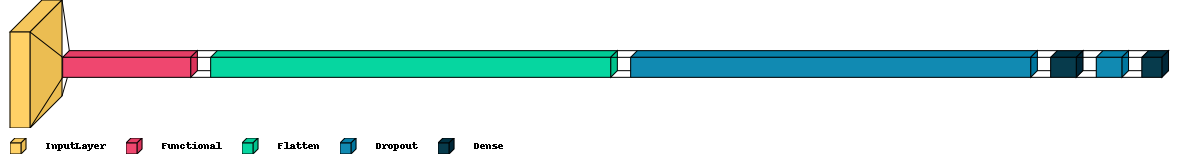

In [13]:
#Build the model
input_shape = X_train.shape[1:]#(None,96,96,3)
batch_size = 128
epochs = 100

model = build_model(input_shape)
model.summary()
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=1)

### Train the model

In [14]:
# Train the model
#Create ALL desired callbacks
callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,where_to_save="./local_checkpoints",patience=15,model_name="Efficent_net_v2B-Base")

#Fit the model
history = model.fit(
    x = X_train_ft,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val_ft, Y_val),
    callbacks = callbacks_selected
).history

Epoch 1/100
98/98 [==============================] - 57s 288ms/step - loss: 1.7221 - accuracy: 0.3864 - F1: 0.2360 - val_loss: 1.1224 - val_accuracy: 0.5881 - val_F1: 0.5370
Epoch 2/100
98/98 [==============================] - 20s 209ms/step - loss: 1.3317 - accuracy: 0.5010 - F1: 0.4017 - val_loss: 1.0238 - val_accuracy: 0.6289 - val_F1: 0.5749
Epoch 3/100
98/98 [==============================] - 19s 195ms/step - loss: 1.2520 - accuracy: 0.5333 - F1: 0.4594 - val_loss: 1.0323 - val_accuracy: 0.6384 - val_F1: 0.5831
Epoch 4/100
98/98 [==============================] - 20s 200ms/step - loss: 1.2013 - accuracy: 0.5590 - F1: 0.4965 - val_loss: 0.9276 - val_accuracy: 0.6792 - val_F1: 0.6394
Epoch 5/100
98/98 [==============================] - 19s 193ms/step - loss: 1.1376 - accuracy: 0.5795 - F1: 0.5277 - val_loss: 0.9146 - val_accuracy: 0.6855 - val_F1: 0.6476
Epoch 6/100
98/98 [==============================] - 19s 192ms/step - loss: 1.1142 - accuracy: 0.5891 - F1: 0.5339 - val_loss: 0.8

In [15]:
model_helper.save_model(model,"EfficientNetV2M-Base")

12/12 [==============================] - 9s 115ms/step
Accuracy: 0.709
Precision: 0.6842
Recall: 0.6668
F1: 0.6678


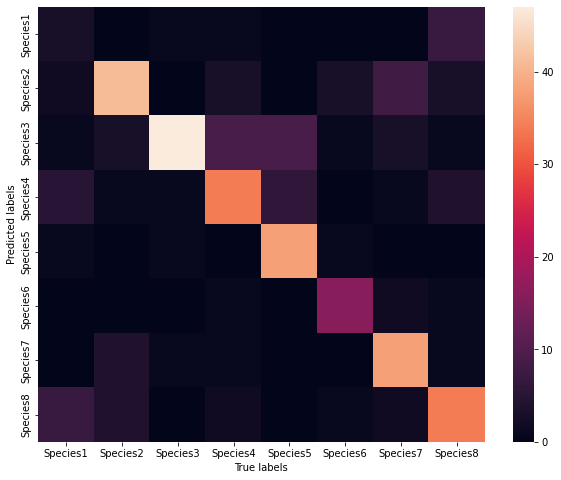

BABABA


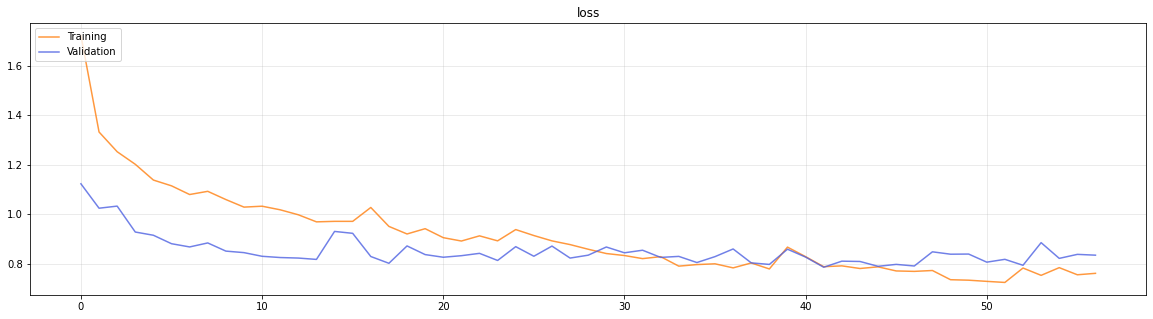

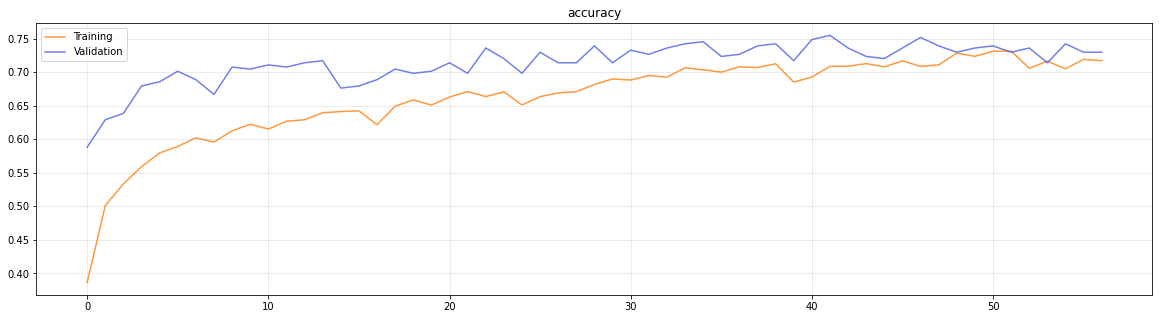

In [16]:
model_helper.show_confusion_matrix(X_test_ft,Y_test)
model_helper.plot_phase_train_vs_validation(history)

# Step 2 -> Fine tuning 100 layer freezed

In [9]:
#ft_model = model_helper.load_model("Xception_Freezed_CNN_AvgPooling3Dense",)
ft_model = tf.keras.models.load_model("local_saved_models/EfficientNetV2M-Base",custom_objects = {"F1":F1})
ft_model.summary()

Model: "Xception"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 efficientnetv2-m (Functiona  (None, 3, 3, 1280)       53150388  
 l)                                                              
                                                                 
 Flattening (Flatten)        (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 classifier_0 (Dense)        (None, 256)               2949376   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                          

In [10]:
# Download and plot the VGG16 model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

X_train_ft  = preprocess_input(X_train*255)
X_val_ft    = preprocess_input(X_val*255)
X_test_ft   = preprocess_input(X_test*255)


In [11]:
num_of_freezed_layer = 500
# Freeze first N layers, e.g., until 14th
ft_model.get_layer('efficientnetv2-m').trainable = True
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-m').layers[:num_of_freezed_layer]):
    layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('efficientnetv2-m').layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block1c_project_conv False
15 block1c_project_bn False
16 block1c_project_activation False
17 block1c_drop False
18 block1c_add False
19 block2a_expand_conv False
20 block2a_expand_bn False
21 block2a_expand_activation False
22 block2a_project_conv False
23 block2a_project_bn False
24 block2b_expand_conv False
25 block2b_expand_bn False
26 block2b_expand_activation False
27 block2b_project_conv False
28 block2b_project_bn False
29 block2b_drop False
30 block2b_add False
31 block2c_expand_conv False
32 block2c_expand_bn False
33 block2c_expand_activation False
34 block2c_project_conv False
35 block2c_project_bn False
36 block2c_drop False
37 block2c_a

In [12]:
# Compile the model
model_name = "EfficientNetV2M-ft-"+str(num_of_freezed_layer) + "-layers"
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy',F1])

In [ ]:
# Train the model
#Create ALL desired callbacks
callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,tensorboard=True,where_to_save="local_checkpoints",patience=15,model_name=model_name)

#Build the model
input_shape = X_train.shape[1:]#(None,96,96,3)
batch_size = 128
epochs = 200

#Fit the model
history = ft_model.fit(
    x = X_train_ft,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val_ft, Y_val),
    callbacks = callbacks_selected
).history

Epoch 1/200


In [ ]:
model_helper.save_model(ft_model,model_name)

In [ ]:
model_helper.show_confusion_matrix(X_test_ft,Y_test)
model_helper.plot_phase_train_vs_validation(history)
print("ciao")

# STEP 3 -> Change augmentation seed and train some other epoche with 150 freezed layer

In [ ]:
dataset_helper.seed = 4349

In [ ]:
#GENERATE 3000 new images
#X_train,Y_train = dataset_helper.apply_data_augmentation_with_classes_distribution(X_train,Y_train,1000,[0.3,0.05,0.05,0.05,0.05,0.3,0.05,0.05])

X_train,Y_train = dataset_helper.apply_data_augmentation_normalized(X_t_original,Y_t_original,10000, disable_tqdm=True,
                                rotation_range=360,
                                width_shift_range=0.4,
                                height_shift_range=0.4,
                                zoom_range=0.8,
                                fill_mode="reflect",
                                horizontal_flip=True,
                                vertical_flip=True,
                                brightness_range=(0.2, 1.5))

Data Augmentation with data distribution
Data distribution = [0.145875 0.117775 0.119075 0.119475 0.117875 0.142875 0.117375 0.119675]
Class Size :  151, generating: 1458
1359 images generated
Class Size :  432, generating: 1177
1120 images generated
Class Size :  419, generating: 1190
1126 images generated
Class Size :  415, generating: 1194
1182 images generated
Class Size :  431, generating: 1178
1118 images generated
Class Size :  181, generating: 1428
1331 images generated
Class Size :  436, generating: 1173
1128 images generated
Class Size :  413, generating: 1196
1178 images generated


In [ ]:
# Download and plot the VGG16 model
from tensorflow.keras.applications.xception import preprocess_input

X_train_ft = preprocess_input(X_train*255)
X_val_ft = preprocess_input(X_val*255)
X_test_ft = preprocess_input(X_test*255)


In [ ]:
# Loads the weights
#Xception-ft-1-layers_Nov19_14-52-47
ft_model.load_weights("./local_checkpoints/cp.ckpt")

# Re-evaluate the model
loss, acc, f1 = ft_model.evaluate(X_test_ft, Y_test, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

12/12 - 11s - loss: 0.8684 - accuracy: 0.8220 - F1: 0.8306 - 11s/epoch - 935ms/step
Restored model, accuracy: 82.20%


In [ ]:
num_of_freezed_layer = 1
# Freeze first N layers, e.g., until 14th
ft_model.get_layer('xception').trainable = True
for i, layer in enumerate(ft_model.get_layer('xception').layers[:num_of_freezed_layer]):
    layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('xception').layers):
    print(i, layer.name, layer.trainable)

0 input_1 False
1 block1_conv1 True
2 block1_conv1_bn True
3 block1_conv1_act True
4 block1_conv2 True
5 block1_conv2_bn True
6 block1_conv2_act True
7 block2_sepconv1 True
8 block2_sepconv1_bn True
9 block2_sepconv2_act True
10 block2_sepconv2 True
11 block2_sepconv2_bn True
12 conv2d True
13 block2_pool True
14 batch_normalization True
15 add True
16 block3_sepconv1_act True
17 block3_sepconv1 True
18 block3_sepconv1_bn True
19 block3_sepconv2_act True
20 block3_sepconv2 True
21 block3_sepconv2_bn True
22 conv2d_1 True
23 block3_pool True
24 batch_normalization_1 True
25 add_1 True
26 block4_sepconv1_act True
27 block4_sepconv1 True
28 block4_sepconv1_bn True
29 block4_sepconv2_act True
30 block4_sepconv2 True
31 block4_sepconv2_bn True
32 conv2d_2 True
33 block4_pool True
34 batch_normalization_2 True
35 add_2 True
36 block5_sepconv1_act True
37 block5_sepconv1 True
38 block5_sepconv1_bn True
39 block5_sepconv2_act True
40 block5_sepconv2 True
41 block5_sepconv2_bn True
42 block5_se

In [ ]:
# Compile the model
model_name = "Xception-ft-"+str(num_of_freezed_layer) + "-layers-Step3"
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics=['accuracy',F1])
model_helper.save_model(ft_model,model_name)

In [ ]:
# Train the model
#Create ALL desired callbacks
callbacks_selected = model_helper.createCallbacks(earlyStopping = True,checkPoints=True,tensorboard=True,patience=15,model_name=model_name)

#Build the model
input_shape = X_train.shape[1:]#(None,96,96,3)
batch_size = 128
epochs = 30

#Fit the model
history = ft_model.fit(
    x = X_train_ft,
    y = Y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val_ft, Y_val),
    callbacks = callbacks_selected
).history

Epoch 1/30
98/98 [==============================] - 62s 536ms/step - loss: 1.0020 - accuracy: 0.6626 - F1: 0.6264 - val_loss: 1.2566 - val_accuracy: 0.7013 - val_F1: 0.7083
Epoch 2/30
98/98 [==============================] - 51s 519ms/step - loss: 0.5109 - accuracy: 0.8213 - F1: 0.8178 - val_loss: 0.8672 - val_accuracy: 0.7358 - val_F1: 0.7490
Epoch 3/30
98/98 [==============================] - 50s 513ms/step - loss: 0.3876 - accuracy: 0.8691 - F1: 0.8637 - val_loss: 1.0234 - val_accuracy: 0.7138 - val_F1: 0.7031
Epoch 4/30
98/98 [==============================] - 51s 521ms/step - loss: 0.3293 - accuracy: 0.8922 - F1: 0.8850 - val_loss: 1.0577 - val_accuracy: 0.7547 - val_F1: 0.7521
Epoch 5/30
98/98 [==============================] - 51s 519ms/step - loss: 0.2485 - accuracy: 0.9204 - F1: 0.9152 - val_loss: 1.4244 - val_accuracy: 0.7390 - val_F1: 0.7420
Epoch 6/30
98/98 [==============================] - 52s 524ms/step - loss: 0.3740 - accuracy: 0.8762 - F1: 0.8731 - val_loss: 1.1040 - 

In [ ]:
#model_name = model_name+"-step3"
model_helper.save_model(ft_model,model_name)

12/12 [==============================] - 2s 36ms/step
Accuracy: 0.8136
Precision: 0.7869
Recall: 0.7751
F1: 0.7763


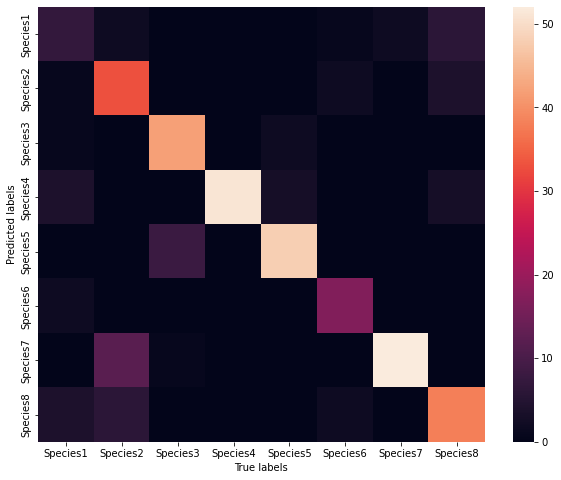

BABABA


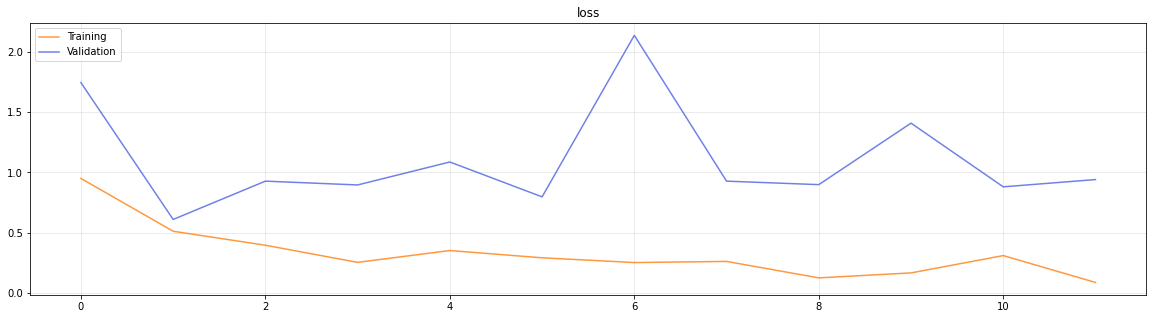

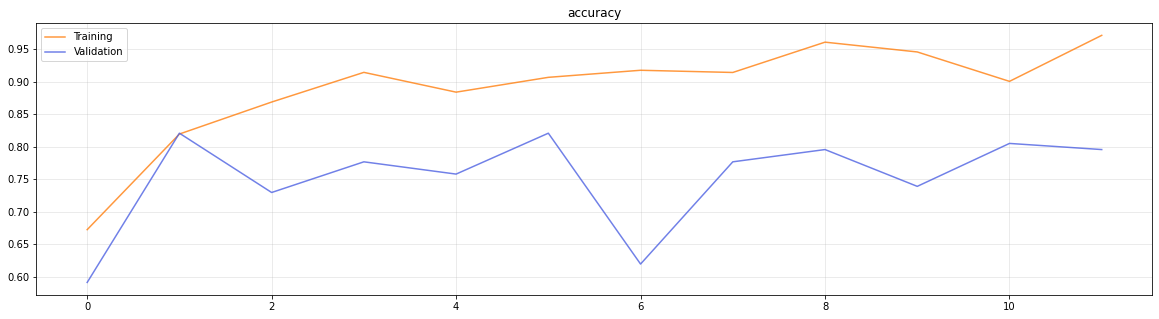

In [ ]:
model_helper.show_confusion_matrix(X_test_ft,Y_test)
model_helper.plot_phase_train_vs_validation(history)